# Lab 3: Model selection: dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [2]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100

In [3]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

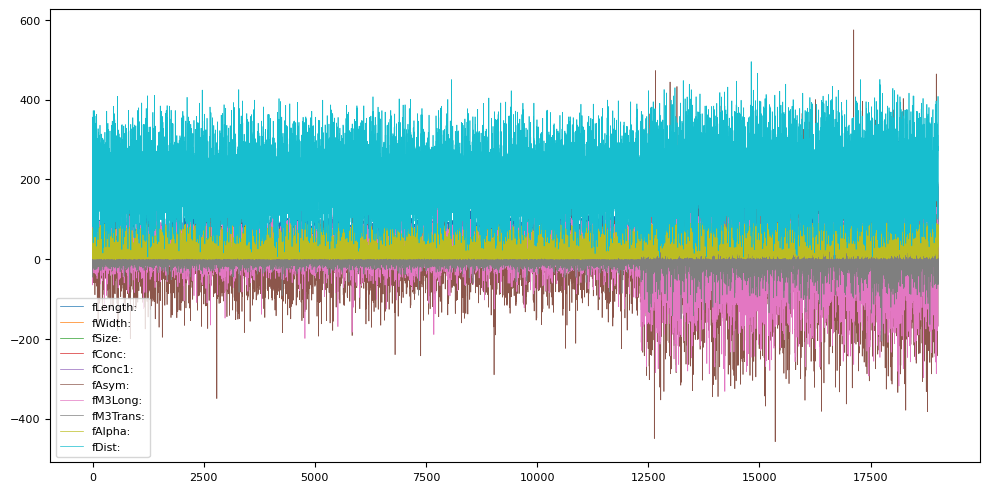

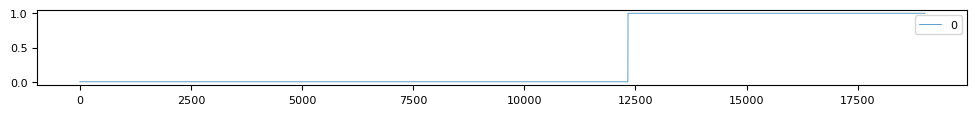

In [4]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y)

def train_SVC(X_train, X_test, y_train, y_test):
    
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    scores = clf.score(X_test, y_test)



    print("Mean accuracy: {:.2f}".format(scores.mean()))

    precision, recall, thresholds = precision_recall_curve(
        y_test, clf.decision_function(X_test))

    print("Mean precision: {:.2f}".format(precision.mean()))

    print("Mean Recall: {:.2f}".format(recall.mean()))

    pred = clf.predict(X_test)
    print("Micro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="micro")))
    print("Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred, average="weighted")))
    print("Macro average f1 score: {:.3f}".format(f1_score(y_test, pred, average="macro")))

    svc_auc = roc_auc_score(y_test, clf.decision_function(X_test))
    print("Mean precision: {:.2f}".format(svc_auc))
    pass

train_SVC(X_train, X_test, y_train, y_test)

"Q1: 0.65"
"Q2: 0.74"

"Q3: ????"




Mean accuracy: 0.82
Mean precision: 0.65
Mean Recall: 0.74
Micro average f1 score: 0.823
Weighted average f1 score: 0.812
Macro average f1 score: 0.786
Mean precision: 0.87


'Q3: ????'

## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [22]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

train_SVC(Xs_train, Xs_test, y_train, y_test)

Mean accuracy: 0.88
Mean precision: 0.68
Mean Recall: 0.77
Micro average f1 score: 0.875
Weighted average f1 score: 0.872
Macro average f1 score: 0.856
Mean precision: 0.93


## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from scipy.stats import expon

param_grid = {'C': np.logspace(-12,12,base=2),
              'gamma': np.logspace(-12,12,base=2)}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(svm.SVC(), param_grid, cv=3)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
svc_auc = roc_auc_score(y_test, clf.decision_function(X_test))
print("Mean precision: {:.2f}".format(svc_auc))


Parameter grid:
{'C': array([   0.   ,    0.   ,    0.   ,    0.001,    0.001,    0.001,
          0.002,    0.003,    0.004,    0.005,    0.007,    0.01 ,
          0.014,    0.02 ,    0.028,    0.04 ,    0.056,    0.078,
          0.11 ,    0.155,    0.217,    0.305,    0.428,    0.601,
          0.844,    1.185,    1.664,    2.337,    3.281,    4.608,
          6.471,    9.086,   12.759,   17.917,   25.16 ,   35.331,
         49.613,   69.669,   97.833,  137.381,  192.917,  270.903,
        380.415,  534.196,  750.142, 1053.384, 1479.211, 2077.177,
       2916.867, 4096.   ]), 'gamma': array([   0.   ,    0.   ,    0.   ,    0.001,    0.001,    0.001,
          0.002,    0.003,    0.004,    0.005,    0.007,    0.01 ,
          0.014,    0.02 ,    0.028,    0.04 ,    0.056,    0.078,
          0.11 ,    0.155,    0.217,    0.305,    0.428,    0.601,
          0.844,    1.185,    1.664,    2.337,    3.281,    4.608,
          6.471,    9.086,   12.759,   17.917,   25.16 ,   35.331,
  

KeyboardInterrupt: 

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?